In [1]:
import os
import pandas as pd

# Function to read all TSV files in a folder and create a dictionary holding the maximum index and sentences for each File Path
def create_index_dict(folder):
    file_dict = {}
    for file_name in os.listdir(folder):
        if file_name.endswith('.tsv'):
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path, sep='\t')
            for file, group in df.groupby('File Name'):
                max_index = group['Index'].max()
                sentences = group[['Index', 'Sentence']].set_index('Index')['Sentence'].to_dict()
                file_dict[file] = {'max_index': max_index, 'sentences': sentences}
    return file_dict

# Folder paths for KSS, Gemini, ChatGPT, KSSDS, and KSSDS (w/o length filter)
kiwi_folder = './TC/JupyterKiwiTC/'       # Folder for Kiwi model
kss_folder = './TC/JupyterKSSTC/'         # Folder for KSS model
gemini_folder = './TC/JupyterGeminiTC/'   # Folder for Gemini model
chatgpt_folder = './TC/JupyterChatGPTTC/' # Folder for ChatGPT model
kssds_folder = './TC/JupyterKSSDSTCNew/'      # Folder for the fine-tuned T5 model (KSSDS)
nolen_folder = './TC/JupyterNoLenTC/'     # Folder for KSSDS (w/o length filter)

# Create dictionaries for each model
kiwi_dict = create_index_dict(kiwi_folder)
kss_dict = create_index_dict(kss_folder)
gemini_dict = create_index_dict(gemini_folder)
chatgpt_dict = create_index_dict(chatgpt_folder)
kssds_dict = create_index_dict(kssds_folder)
nolen_dict = create_index_dict(nolen_folder)

# Print how many files were loaded for each model
print(f"Kiwi: {len(kiwi_dict)} files loaded")
print(f"KSS: {len(kss_dict)} files loaded")
print(f"Gemini: {len(gemini_dict)} files loaded")
print(f"ChatGPT: {len(chatgpt_dict)} files loaded")
print(f"KSSDS: {len(kssds_dict)} files loaded")
print(f"KSSDS (w/o length filter): {len(nolen_dict)} files loaded")


Kiwi: 195 files loaded
KSS: 195 files loaded
Gemini: 195 files loaded
ChatGPT: 195 files loaded
KSSDS: 195 files loaded
KSSDS (w/o length filter): 195 files loaded


In [2]:

import re
punctuation_regex = re.compile(r'[.!?]$')
# Function to count the total number of sentences for each model

def count_total_sentences_with_nan(model_dict):
    total_sentences = 0
    punc_sentences = 0
    nan_sentences = 0
    for file_path, file_data in model_dict.items():
        for sentence in file_data['sentences'].values():
            if pd.isna(sentence):  # Count NaN (blank) sentences
                nan_sentences += 1
                # print(f"Non-string sentence found in {file_path}: {sentence} (type: {type(sentence)})")
                continue
            if isinstance(sentence, str):  # Count valid sentences
                total_sentences += 1
                if punctuation_regex.search(sentence):  # Count sentences ending with punctuation
                    punc_sentences += 1
    return total_sentences, punc_sentences, nan_sentences


# Calculate total, punctuation-ending, and NaN sentence counts for each model
total_sentences_kiwi, punc_sentences_kiwi, nan_sentences_kiwi = count_total_sentences_with_nan(kiwi_dict)
total_sentences_kss, punc_sentences_kss, nan_sentences_kss = count_total_sentences_with_nan(kss_dict)
total_sentences_gemini, punc_sentences_gemini, nan_sentences_gemini = count_total_sentences_with_nan(gemini_dict)
total_sentences_chatgpt, punc_sentences_chatgpt, nan_sentences_chatgpt = count_total_sentences_with_nan(chatgpt_dict)
total_sentences_ours, punc_sentences_ours, nan_sentences_ours = count_total_sentences_with_nan(kssds_dict)
total_sentences_nolen, punc_sentences_nolen, nan_sentences_nolen = count_total_sentences_with_nan(nolen_dict)

# Print total sentence counts for each model
print(f"Punc/Total sentences for Kiwi: {punc_sentences_kiwi}/{total_sentences_kiwi}")
print(f"Punc/Total sentences for KSS: {punc_sentences_kss}/{total_sentences_kss}")
print(f"Punc/Total sentences for Gemini: {punc_sentences_gemini}/{total_sentences_gemini}")
print(f"Punc/Total sentences for ChatGPT: {punc_sentences_chatgpt}/{total_sentences_chatgpt}")
print(f"Punc/Total sentences for KSSDS: {punc_sentences_ours}/{total_sentences_ours}")
print(f"Punc/Total sentences for KSSDS(w/o length filter): {punc_sentences_nolen}/{total_sentences_nolen}")

# Calculate and print the ratio of sentences ending with punctuation for each model
def calculate_punctuation_ratio(total_sentences, punc_sentences):
    return ((punc_sentences / total_sentences) * 100) if total_sentences > 0 else 0

print(f"\nKiwi model punctuation ratio: {calculate_punctuation_ratio(total_sentences_kiwi, punc_sentences_kiwi):.2f}%")
print(f"KSS model punctuation ratio: {calculate_punctuation_ratio(total_sentences_kss, punc_sentences_kss):.2f}%")
print(f"Gemini model punctuation ratio: {calculate_punctuation_ratio(total_sentences_gemini, punc_sentences_gemini):.2f}%")
print(f"ChatGPT model punctuation ratio: {calculate_punctuation_ratio(total_sentences_chatgpt, punc_sentences_chatgpt):.2f}%")
print(f"KSSDS model punctuation ratio: {calculate_punctuation_ratio(total_sentences_ours, punc_sentences_ours):.2f}%")
print(f"KSSDS (w/o length filter) model punctuation ratio: {calculate_punctuation_ratio(total_sentences_nolen, punc_sentences_nolen):.2f}%")

Punc/Total sentences for Kiwi: 35129/40378
Punc/Total sentences for KSS: 33143/39193
Punc/Total sentences for Gemini: 36060/37956
Punc/Total sentences for ChatGPT: 38289/38312
Punc/Total sentences for KSSDS: 35108/40348
Punc/Total sentences for KSSDS(w/o length filter): 35061/40125

Kiwi model punctuation ratio: 87.00%
KSS model punctuation ratio: 84.56%
Gemini model punctuation ratio: 95.00%
ChatGPT model punctuation ratio: 99.94%
KSSDS model punctuation ratio: 87.01%
KSSDS (w/o length filter) model punctuation ratio: 87.38%


In [3]:
# Function to calculate sentence lengths for each model
def calculate_sentence_lengths(model_dict):
    sentence_lengths = []
    for file_path, file_data in model_dict.items():
        for sentence in file_data['sentences'].values():
            if pd.isna(sentence):
                continue
            sentence_lengths.append(len(sentence))  # Measure the length of each sentence (in characters)
    return sentence_lengths

# Calculate sentence lengths for each model
kiwi_lengths = calculate_sentence_lengths(kiwi_dict)
kss_lengths = calculate_sentence_lengths(kss_dict)
gemini_lengths = calculate_sentence_lengths(gemini_dict)
chatgpt_lengths = calculate_sentence_lengths(chatgpt_dict)
ours_lengths = calculate_sentence_lengths(kssds_dict)
nolen_lengths = calculate_sentence_lengths(nolen_dict)

# Print some statistics about sentence lengths
print(f"Kiwi: Average sentence length: {sum(kiwi_lengths)/len(kiwi_lengths):.2f}")
print(f"KSS: Average sentence length: {sum(kss_lengths)/len(kss_lengths):.2f}")
print(f"Gemini: Average sentence length: {sum(gemini_lengths)/len(gemini_lengths):.2f}")
print(f"ChatGPT: Average sentence length: {sum(chatgpt_lengths)/len(chatgpt_lengths):.2f}")
print(f"KSSDS: Average sentence length: {sum(ours_lengths)/len(ours_lengths):.2f}")
print(f"KSSDS (w/o length filter): Average sentence length: {sum(nolen_lengths)/len(nolen_lengths):.2f}")


Kiwi: Average sentence length: 23.81
KSS: Average sentence length: 24.56
Gemini: Average sentence length: 25.42
ChatGPT: Average sentence length: 25.38
KSSDS: Average sentence length: 23.83
KSSDS (w/o length filter): Average sentence length: 23.97


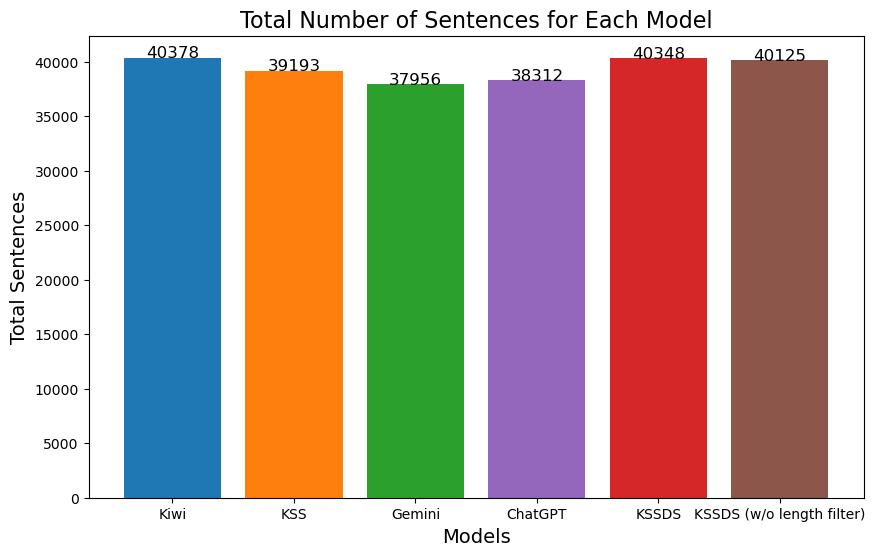

In [4]:
import matplotlib.pyplot as plt

# Plotting total sentences
models = ['Kiwi', 'KSS', 'Gemini', 'ChatGPT', 'KSSDS', 'KSSDS (w/o length filter)']
total_sentences = [total_sentences_kiwi, total_sentences_kss, total_sentences_gemini, total_sentences_chatgpt, total_sentences_ours, total_sentences_nolen]

plt.figure(figsize=(10, 6))
plt.bar(models, total_sentences, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#8c564b'])
plt.title('Total Number of Sentences for Each Model', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Total Sentences', fontsize=14)

# Annotate the bars with the total sentence numbers
for i, v in enumerate(total_sentences):
    plt.text(i, v + 10, str(v), ha='center', fontsize=12)
plt.savefig("total_num_sent_validation", dpi=300, bbox_inches='tight')
plt.show()


In [5]:
import numpy as np

# Calculate mean and standard deviation for all models
kiwi_mean, kiwi_std = np.mean(kiwi_lengths), np.std(kiwi_lengths)
kss_mean, kss_std = np.mean(kss_lengths), np.std(kss_lengths)
gemini_mean, gemini_std = np.mean(gemini_lengths), np.std(gemini_lengths)
chatgpt_mean, chatgpt_std = np.mean(chatgpt_lengths), np.std(chatgpt_lengths)
ours_mean, ours_std = np.mean(ours_lengths), np.std(ours_lengths)
nolen_mean, nolen_std = np.mean(nolen_lengths), np.std(nolen_lengths)


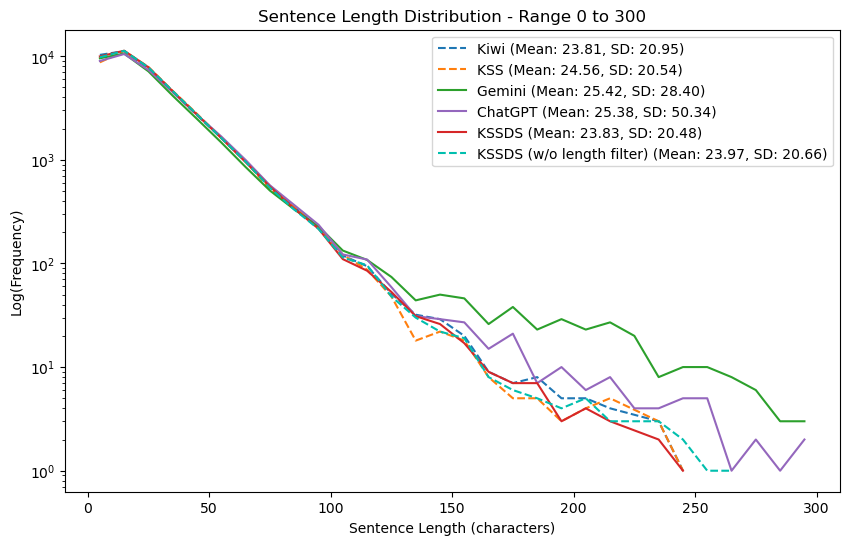

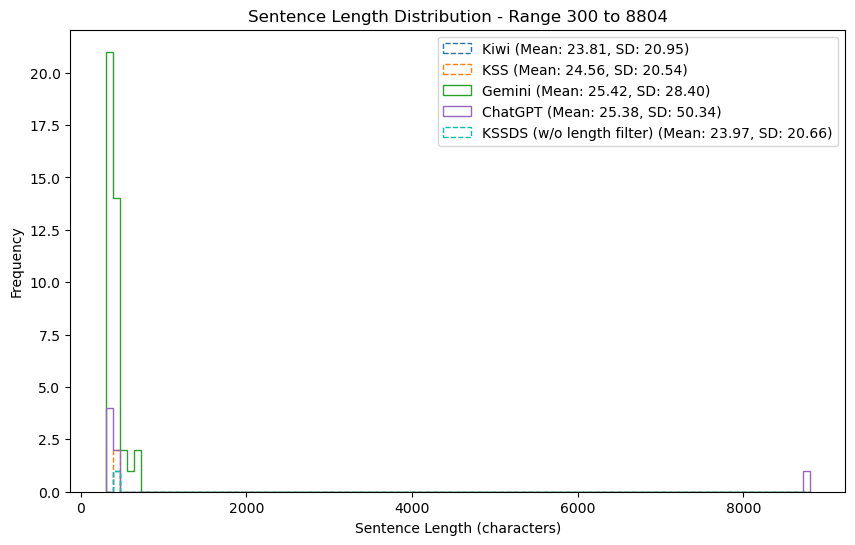

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dynamic_histogram(log_x=False, log_y=False, log_both=False, range_min=0, range_max=None, bins=100, use_smoothed=False):
    # Handle log scaling
    scale_x = 'log' if log_x or log_both else 'linear'
    scale_y = 'log' if log_y or log_both else 'linear'

    # Determine the range max if not specified
    if range_max is None:
        range_max = max(
            max(kss_lengths), max(gemini_lengths), max(chatgpt_lengths), 
            max(ours_lengths), max(kiwi_lengths), max(nolen_lengths)
        )

    # Define line styles and colors for distinguishability
    line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (5, 10))]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#00bfae']

    # Prepare the figure
    plt.figure(figsize=(10, 6))

    # Helper function to plot smoothed histograms
    def plot_smoothed_line(data, label, color, linestyle):
        hist, bin_edges = np.histogram(data, bins=bins, range=(range_min, range_max))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
        non_zero_indices = np.where(hist > 0)[0]
        if len(non_zero_indices) > 0:
            valid_bin_centers = bin_centers[non_zero_indices]
            valid_hist = hist[non_zero_indices]
            plt.plot(valid_bin_centers, valid_hist, linestyle=linestyle, label=label, color=color)

    # Helper function to plot step histograms
    def plot_step_histogram(data, label, color, linestyle):
        plt.hist(data, bins=bins, histtype='step', linestyle=linestyle, label=label, color=color, range=(range_min, range_max))

    # Choose plotting style based on `use_smoothed` flag
    plot_function = plot_smoothed_line if use_smoothed else plot_step_histogram

    # Plot each dataset dynamically
    plot_function(kiwi_lengths, f'Kiwi (Mean: {kiwi_mean:.2f}, SD: {kiwi_std:.2f})', colors[0], line_styles[1])
    plot_function(kss_lengths, f'KSS (Mean: {kss_mean:.2f}, SD: {kss_std:.2f})', colors[1], line_styles[1])
    plot_function(gemini_lengths, f'Gemini (Mean: {gemini_mean:.2f}, SD: {gemini_std:.2f})', colors[2], line_styles[0])
    plot_function(chatgpt_lengths, f'ChatGPT (Mean: {chatgpt_mean:.2f}, SD: {chatgpt_std:.2f})', colors[3], line_styles[0])
    if range_max <= 300 or max(ours_lengths) > 300:
        plot_function(ours_lengths, f'KSSDS (Mean: {ours_mean:.2f}, SD: {ours_std:.2f})', colors[4], line_styles[0])
    plot_function(nolen_lengths, f'KSSDS (w/o length filter) (Mean: {nolen_mean:.2f}, SD: {nolen_std:.2f})', colors[5], line_styles[1])

    # Set log scales if specified
    plt.xscale(scale_x)
    plt.yscale(scale_y)

    # Add labels and legend
    plt.title(f'Sentence Length Distribution - Range {range_min} to {range_max}')
    plt.xlabel('Sentence Length (characters)')
    plt.ylabel('Log(Frequency)' if scale_y == 'log' else 'Frequency')
    plt.legend(loc='upper right', fontsize=10)

    # Save and show the plot
    plot_type = "smoothed" if use_smoothed else "step"
    plt.savefig(f"dynamic_histogram_{plot_type}_{range_min}_{range_max}", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# Smoothed histogram for range 0-300
plot_dynamic_histogram(log_y=True, range_min=0, range_max=300, bins=30, use_smoothed=True)

# Step histogram for range 300+
plot_dynamic_histogram(range_min=300, bins=100, use_smoothed=False)


In [7]:
# Prepare data with sentence lengths for each model
kiwi_data = [(file_path, len(sentence)) for file_path, data in kiwi_dict.items() for idx, sentence in data['sentences'].items()]
kss_data = [(file_path, len(sentence)) for file_path, data in kss_dict.items() for idx, sentence in data['sentences'].items()]
gemini_data = [(file_path, len(sentence)) for file_path, data in gemini_dict.items() for idx, sentence in data['sentences'].items()]
chatgpt_data = [(file_path, len(sentence)) for file_path, data in chatgpt_dict.items() for idx, sentence in data['sentences'].items()]
ours_data = [(file_path, len(sentence)) for file_path, data in kssds_dict.items() for idx, sentence in data['sentences'].items()]

# Skip NaN values in nolen_dict
nolen_data = [
    (file_path, len(sentence)) 
    for file_path, data in nolen_dict.items() 
    for idx, sentence in data['sentences'].items() 
    if isinstance(sentence, str) and sentence.strip()  # Skip NaN or blank sentences
]

# Sort by sentence length and get the top 15 longest sentences for each model
top_15_kiwi = sorted(kiwi_data, key=lambda x: x[1], reverse=True)[:15]
top_15_kss = sorted(kss_data, key=lambda x: x[1], reverse=True)[:15]
top_15_gemini = sorted(gemini_data, key=lambda x: x[1], reverse=True)[:15]
top_15_chatgpt = sorted(chatgpt_data, key=lambda x: x[1], reverse=True)[:15]
top_15_ours = sorted(ours_data, key=lambda x: x[1], reverse=True)[:15]
top_15_nolen = sorted(nolen_data, key=lambda x: x[1], reverse=True)[:15]

# Function to display the top 15 longest sentences for a given model
def display_top_15_sentences(model_name, top_15_data):
    print(f"\nTop 15 Longest Sentence Lengths for {model_name}:")
    for i, (file_path, length) in enumerate(top_15_data, start=1):
        base_name = os.path.basename(file_path)
        print(f"{i}. {base_name}: {length} characters")

# Display results for all models
display_top_15_sentences('Kiwi', top_15_kiwi)
display_top_15_sentences('KSS', top_15_kss)
display_top_15_sentences('Gemini', top_15_gemini)
display_top_15_sentences('ChatGPT', top_15_chatgpt)
display_top_15_sentences('KSSDS', top_15_ours)
display_top_15_sentences('KSSDS (w/o length filter)', top_15_nolen)


Top 15 Longest Sentence Lengths for Kiwi:
1. 20127_미안하다.wav: 467 characters
2. 70008_미안하다.wav: 248 characters
3. 15399_미안하다.wav: 233 characters
4. 30023_힘들다.wav: 231 characters
5. AHAAR21000940.wav: 231 characters
6. DGAAR21000621.wav: 219 characters
7. 16033_미안하다.wav: 217 characters
8. AHAAR21001148.wav: 213 characters
9. 13012_힘들다.wav: 211 characters
10. 51025_미안하다.wav: 207 characters
11. 15603_힘들다.wav: 203 characters
12. 60024_외롭다.wav: 201 characters
13. 60131_힘들다.wav: 201 characters
14. AHAAR21000444.wav: 200 characters
15. 20816_미안하다.wav: 199 characters

Top 15 Longest Sentence Lengths for KSS:
1. 20127_미안하다.wav: 467 characters
2. 15603_힘들다.wav: 407 characters
3. 70008_미안하다.wav: 248 characters
4. 15399_미안하다.wav: 233 characters
5. 30023_힘들다.wav: 231 characters
6. AHAAR21000940.wav: 231 characters
7. DGAAR21000621.wav: 219 characters
8. 16033_미안하다.wav: 217 characters
9. AHAAR21001148.wav: 213 characters
10. 13012_힘들다.wav: 211 characters
11. DGAAR21000450.wav: 211 characters
12. 206

In [8]:
# Dictionary that maps model names to their corresponding data dictionaries
model_dicts = {
    'Kiwi': kiwi_dict,
    'Gemini': gemini_dict,
    'ChatGPT': chatgpt_dict,
    'KSSDS': kssds_dict,
    'KSSDS (w/o length filter)': nolen_dict
}

# Function to display sentences for a specific file path from "Ours" and a specified model
def display_sentences_for_file(file_path, compare_model):
    # Extract the base name from the file path
    base_file_name = os.path.basename(file_path)
    
    # Initialize variable to store the matched file paths
    ours_file_path = None
    compare_file_path = None

    # Check if the base name exists in Ours dictionary
    for key in kssds_dict.keys():
        if os.path.basename(key) == base_file_name:
            ours_file_path = key
            break

    # Check if the base name exists in the compare_model dictionary
    model_dict = model_dicts.get(compare_model)
    if model_dict:
        for key in model_dict.keys():
            if os.path.basename(key) == base_file_name:
                compare_file_path = key
                break

    # Validate file paths
    if not ours_file_path:
        print(f"File Path '{base_file_name}' not found in 'KSSDS' data.")
        return
    
    if not compare_file_path:
        print(f"File Path '{base_file_name}' not found in '{compare_model}' data.")
        return

    # Adjust pandas options to display all rows and columns without truncation
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.max_colwidth', None)  # Show full width of each column
    pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

    # Get sentences for the provided file path from Ours and the comparison model
    ours_sentences = kssds_dict[ours_file_path]['sentences']
    compare_model_sentences = model_dict[compare_file_path]['sentences']

    # Create a DataFrame by merging the sentences based on their Index
    merged_df = pd.DataFrame({
        'Index': sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys())),
        'Ours Transcription': [ours_sentences.get(idx, '') for idx in sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys()))],
        f'{compare_model} Transcription': [compare_model_sentences.get(idx, '') for idx in sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys()))]
    })

    # Apply styling to hide index and set custom column widths
    styled_df = merged_df.style.set_table_attributes('style="width: auto;"') \
        .set_table_styles({
            'Ours Transcription': [{'selector': 'td', 'props': [('max-width', '450px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis'), ('white-space', 'normal'), ('text-align', 'left')]}],
            f'{compare_model} Transcription': [{'selector': 'td', 'props': [('max-width', '450px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis'), ('white-space', 'normal'), ('text-align', 'left')]}],
            'Index': [{'selector': 'td', 'props': [('width', '50px'), ('text-align', 'center')]}]  # Center align Index column
        }) \
        .hide(axis="index")  # Hide the DataFrame index

    # Display the styled DataFrame
    display(styled_df)


In [9]:
display_sentences_for_file("15603_힘들다.wav", "KSSDS (w/o length filter)")

Index,Ours Transcription,KSSDS (w/o length filter) Transcription
0,여보세요 네 지금 녹음 시작합니다,여보세요 네 지금 녹음 시작합니다
1,네 네 힘들다라는 단어를 들으면 떠오르는 기억에 대해서 말씀해 주시면 됩니다,네 네 힘들다라는 단어를 들으면 떠오르는 기억에 대해서 말씀해 주시면 됩니다
2,힘들다 힘들다요,힘들다 힘들다요
3,네 힘든 일이 많죠,네 힘든 일이 많죠
4,여보세요?,여보세요?
5,힘든 일이 많죠.,힘든 일이 많죠.
6,힘들다 얘기하면 떠오르는 게 있죠.,힘들다 얘기하면 떠오르는 게 있죠.
7,저는 처음에 결혼을 해가지고 일을 할 줄 몰라가지고 밥 같은 것도 할 줄 모르고 이래가지고 있잖아요.,저는 처음에 결혼을 해가지고 일을 할 줄 몰라가지고 밥 같은 것도 할 줄 모르고 이래가지고 있잖아요.
8,그거 배우는 데가 반찬 만들고 이런 게 굉장히 힘들었어요.,그거 배우는 데가 반찬 만들고 이런 게 굉장히 힘들었어요.
9,힘들었는데 어떤 게 생각나게 하면 처음에 결혼해서 시댁에 갔는데 빨래 같은 것도 안 해봐서 세탁기를 돌려야 하는데 세탁기 돌리면 흰 빨래는 흰 빨래대로 까만 빨래는 까만 빨래 해야 하잖아요.,힘들었는데 어떤 게 생각나게 하면 처음에 결혼해서 시댁에 갔는데 빨래 같은 것도 안 해봐서 세탁기를 돌려야 하는데 세탁기 돌리면 흰 빨래는 흰 빨래대로 까만 빨래는 까만 빨래 해야 하잖아요.


In [10]:
display_sentences_for_file("DGAAR21000576.wav", "Gemini")

Index,Ours Transcription,Gemini Transcription
0,예전에 먹던 술빵 찐빵 생각나세요?,예전에 먹던 술빵 찐빵 생각나세요?
1,뭐 가게에서 파는 빵보다 모양도 투박하고 맛은 덜해도요.,뭐 가게에서 파는 빵보다 모양도 투박하고 맛은 덜해도요.
2,엄마의 손맛이 담겨있어서 그런지 몰라도 더 좋았거든요.,엄마의 손맛이 담겨있어서 그런지 몰라도 더 좋았거든요.
3,요즘은 말이죠.,요즘은 말이죠.
4,오븐이 대중화돼서 웬만한 가정에는 오븐이나 제빵기가 있잖아요.,오븐이 대중화돼서 웬만한 가정에는 오븐이나 제빵기가 있잖아요.
5,예전에 비하면 참 얼마나 쉬워진 겁니까?,예전에 비하면 참 얼마나 쉬워진 겁니까?
6,자 오늘 오랜만에 가족들을 위해서 솜씨 한번 발휘해보시죠.,자 오늘 오랜만에 가족들을 위해서 솜씨 한번 발휘해보시죠.
7,자 오븐 예열해 놓으셨습니까?,자 오븐 예열해 놓으셨습니까?
8,자 최고의 요리 비결 오늘도요.,자 최고의 요리 비결 오늘도요.
9,선생님과 함께 반죽하고 치대고 구워내봅시다.,선생님과 함께 반죽하고 치대고 구워내봅시다.


In [11]:
display_sentences_for_file("20127_미안하다.wav", "ChatGPT") 

Index,Ours Transcription,ChatGPT Transcription
0,아 맞아요,아 맞아요 그리고 이제 지금은 단어가 미안하다 에요.
1,그리고 이제 지금은 단어가 미안하다 에요,선생님이 60평생 동안 내 느낌으로 내가 이제 미안하다고 느낀 거에 대해서 구체적으로 연애했는데 조금 맘에 안 들어서 나는 이 사람하고 결혼하겠다.
2,선생님이 60평생 동안 내 느낌으로 내가 이제 미안하다고 느낀 거에 대해서 구체적으로 연애했는데 조금 맘에 안 들어서 나는 이 사람하고 결혼하겠다.,그래서 좀 미안하죠.
3,그래서 좀 미안하죠.,부모한테.
4,부모한테.,부모한테 미안했고.
5,부모한테 미안했고.,남한테는 내 마음대로 되는 건 아니지만 딸이 없어서 미안하고.
6,남한테는 내 마음대로 되는 건 아니지만 딸이 없어서 미안하고.,나도 그게 되게 서운해.
7,나도 그게 되게 서운해.,섭섭하거든요.
8,섭섭하거든요.,어쩔 수 없지만.
9,어쩔 수 없지만.,왜 안 나셨어요? 하나만.
